# Import Libraries 

In [9]:
%matplotlib inline

In [ ]:
"""
One layer Binary Helmholtz Machine
==================================
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data


if not os.path.exists('out/'):
    os.makedirs('out/')

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

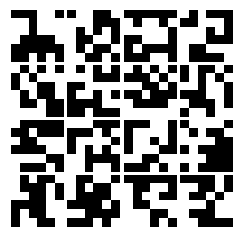

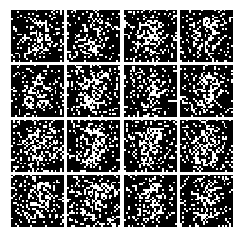

In [11]:
mb_size = 16
h_dim = 36

# Recognition/inference weight
R = np.random.randn(X_dim, h_dim) * 0.001
# Generative weight
W = np.random.randn(h_dim, X_dim) * 0.001
# Generative bias of hidden variables
B = np.random.randn(h_dim) * 0.001


def sigm(x):
    return 1/(1 + np.exp(-x))


def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ R)


def generate(H):
    # mb_size x h_dim -> mb_size x x_dim
    return sigm(H @ W)


# Wake-Sleep Algorithm
# --------------------
alpha = 0.1

for t in range(1, 1001):
    # ----------
    # Wake phase
    # ----------

    # Upward pass
    X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
    H = np.random.binomial(n=1, p=infer(X_mb))

    # Downward pass
    H_prime = sigm(B)
    V = generate(H)

    # Compute gradient
    dB = H - H_prime
    dW = np.array([np.outer(H[i], X_mb[i] - V[i]) for i in range(mb_size)])

    # Update generative weight
    B += (alpha/t) * np.mean(dB, axis=0)
    W += (alpha/t) * np.mean(dW, axis=0)

    # -----------
    # Sleep phase
    # -----------

    # Downward pass
    H_mb = np.random.binomial(n=1, p=sigm(B))
    V = np.random.binomial(n=1, p=generate(H_mb))

    # Upward pass
    H = infer(V)

    # Compute gradient
    dR = np.array([np.outer(V, H_mb[i] - H[i]) for i in range(mb_size)])

    # Update recognition weight
    R += (alpha/t) * np.mean(dR, axis=0)


# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')

    plt.savefig('out/{}.png'.format(name), bbox_inches='tight')
   # plt.close(fig)


X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)

H = np.random.binomial(n=1, p=infer(X))
plot(H, np.sqrt(h_dim), 'H')

X_recon = np.random.binomial(n=1, p=generate(H))
plot(X_recon, np.sqrt(X_dim), 'V')